<a href="https://colab.research.google.com/github/PetroRudyi/DOU_2022_salary/blob/main/DOU_Summer_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What this it?

In this notebook I tried to create a model for forecasting the salaries of specialists based on data from the survey of the Ukrainian forum DOU for summer 2022 (https://github.com/devua/csv/tree/master/salaries)


# How to use

1.   CTRL + F9 (Run All)
2.   Move to 'Interface' in the end

#Imports

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Load dataset


In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IkVZk-05hP4oHjmrkwRQW_Qg89L9O2qJ' -O data.csv

--2023-11-30 11:33:41--  https://docs.google.com/uc?export=download&id=1IkVZk-05hP4oHjmrkwRQW_Qg89L9O2qJ
Resolving docs.google.com (docs.google.com)... 172.253.122.101, 172.253.122.100, 172.253.122.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.122.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t2ih6mjha9agbkpl72lu86gm6dhukdgo/1701343950000/08781303206472352078/*/1IkVZk-05hP4oHjmrkwRQW_Qg89L9O2qJ?e=download&uuid=7d572e6d-6dfc-4e70-949b-918980b4a0bc [following]
--2023-11-30 11:33:41--  https://doc-04-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t2ih6mjha9agbkpl72lu86gm6dhukdgo/1701343950000/08781303206472352078/*/1IkVZk-05hP4oHjmrkwRQW_Qg89L9O2qJ?e=download&uuid=7d572e6d-6dfc-4e70-949b-918980b4a0bc
Resolving doc-04-ag-docs.googleusercontent.com (doc-04-ag-docs.googleusercontent.com)... 172.253.63.132, 2607:f

In [3]:
df = pd.read_csv('data.csv')
df.head()

,city,experience,salary,position,freq
0,Вінниця,1-3 роки,0 - 500,DevOps Engineer,1
1,Вінниця,1-3 роки,0 - 500,Other,1
2,Вінниця,1-3 роки,0 - 500,Project Manager,1
3,Вінниця,1-3 роки,0 - 500,Recruiter,1
4,Вінниця,1-3 роки,0 - 500,Talent Acquisition Manager,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7468 entries, 0 to 7467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        7468 non-null   object
 1   experience  7468 non-null   object
 2   salary      7468 non-null   object
 3   position    7468 non-null   object
 4   freq        7468 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 291.8+ KB


#Data research

## General view

Features meaning:
*   city
*   experience
*   salary - salary range
*   position
*   freq - users count who meets these parameters


In [5]:
df.loc[(df['position']=='DevOps Engineer') & (df['city']=='Київ') & (df['experience']=='1-3 роки')]

,city,experience,salary,position,freq
1389,Київ,1-3 роки,1000 - 1500,DevOps Engineer,6
1429,Київ,1-3 роки,1500 - 2000,DevOps Engineer,5
1462,Київ,1-3 роки,2000 - 2500,DevOps Engineer,6
1486,Київ,1-3 роки,2500 - 3000,DevOps Engineer,13
1507,Київ,1-3 роки,3000 - 3500,DevOps Engineer,7
1525,Київ,1-3 роки,3500 - 4000,DevOps Engineer,2
1536,Київ,1-3 роки,4000 - 4500,DevOps Engineer,5
1549,Київ,1-3 роки,4500 - 5000,DevOps Engineer,4
1597,Київ,1-3 роки,5000 - 5500,DevOps Engineer,2
1606,Київ,1-3 роки,5500 - 6000,DevOps Engineer,3


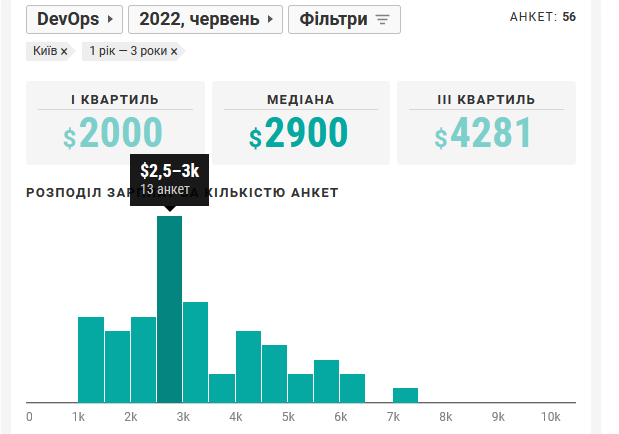


From this comparison with [photo](https://jobs.dou.ua/salaries/?period=2022-06&position=DevOps&city=1&experience=1-3) we can see that these are not data for each user separately, but general results that can get for appropriate sorting on the DOU website (summer 2022).

Therefore, the question arises of the feasibility of using the values ​​"All cities", "All experience" and "All" of the City, Experience, Position columns in training, because the data described without these values ​​are already included in them. That is, in the fields city - "All cities" all user questionnaires that correspond to the selected "experience", "salary", "position", that is, the data are repeated.

In turn, the data for other years simply have survey results, so based on this, I will try to make models that predict the results of filtering, which is what this dataset is.

`freq` shows the number of questionnaires that correspond to the given filtering by parameters, so if we delete all the results that contain "All cities", "All experience" and "All", we will get clean user data, but without the possibility of generalization.

I will try to implement the models so and so.
But upon further investigation, there will be noticeable signs that the net user data has a linear regression.

In [6]:
#@title Sorting salary and expirience parameters
sorted_salary = ['0 - 500', '500 - 1000', '1000 - 1500',
                  '1500 - 2000', '2000 - 2500', '2500 - 3000',
                  '3000 - 3500', '3500 - 4000', '4000 - 4500',
                  '4500 - 5000', '5000 - 5500', '5500 - 6000',
                  '6000 - 6500', '6500 +']

dict_salary_ids = {}
for i in range(len(sorted_salary)):
  dict_salary_ids[sorted_salary[i]] = i

sorted_expirience = ['До року', '1-3 роки', '4-6 років', '7-10 років',
                     '10+ років', '15  і більше років', 'Весь досвід']

salary_len_check = len(sorted_salary) == len(df['salary'].unique())
experience_len_check = len(sorted_expirience) == len(df['experience'].unique())

if salary_len_check and experience_len_check:
  df['experience'] = pd.Categorical(df['experience'],
                                        categories=sorted_expirience, ordered=True)
  df['salary'] = pd.Categorical(df['salary'],
                                        categories=sorted_salary, ordered=True)

  df['salary_idx'] = df['salary'].map(dict_salary_ids)
  df['salary_idx'] = pd.to_numeric(df['salary_idx'])

  print(f'All sorted: \nsalary - {salary_len_check}\nexperience - {experience_len_check}')

else:
  print(f'Something wrong: \nsalary - {salary_len_check}\nexperience - {experience_len_check}')


All sorted: 
salary - True
experience - True


In [7]:
print(f"City labels count: {df['city'].nunique()}")
print(f"Experience labels counts: {df['experience'].nunique()}")
print(f"Salary labels count: {df['salary'].nunique()}")
print(f"Position labels count: {df['position'].nunique()}")
print(f"Total number of results: {df['freq'].sum()}")

City labels count: 9
Experience labels counts: 7
Salary labels count: 14
Position labels count: 73
Total number of results: 39880


In [8]:
# unpacked dataset
df_unpacked = df.loc[df.index.repeat(df['freq'])].reset_index(drop=True)
df_unpacked

,city,experience,salary,position,freq,salary_idx
0,Вінниця,1-3 роки,0 - 500,DevOps Engineer,1,0
1,Вінниця,1-3 роки,0 - 500,Other,1,0
2,Вінниця,1-3 роки,0 - 500,Project Manager,1,0
3,Вінниця,1-3 роки,0 - 500,Recruiter,1,0
4,Вінниця,1-3 роки,0 - 500,Talent Acquisition Manager,1,0
...,...,...,...,...,...,...
39875,Всі міста,Весь досвід,6500 +,Всі,238,13
39876,Всі міста,Весь досвід,6500 +,Всі,238,13
39877,Всі міста,Весь досвід,6500 +,Всі,238,13
39878,Всі міста,Весь досвід,6500 +,Всі,238,13


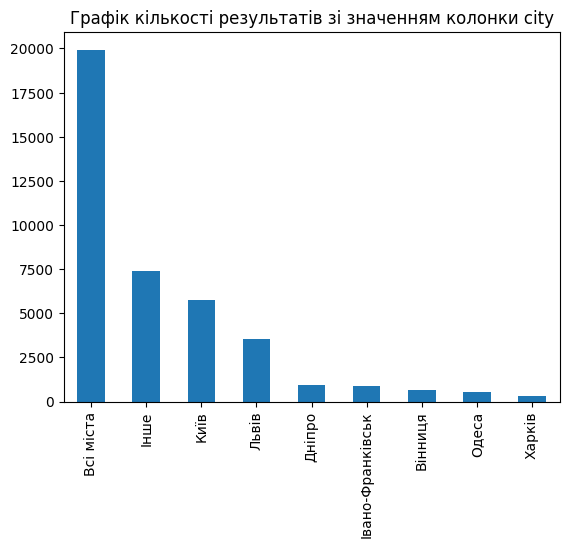

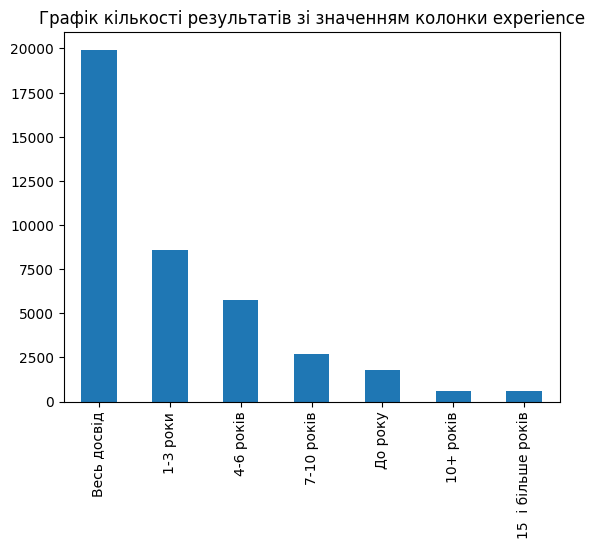

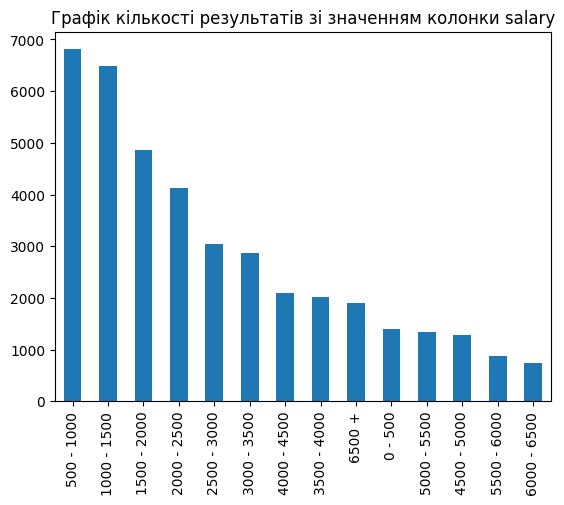

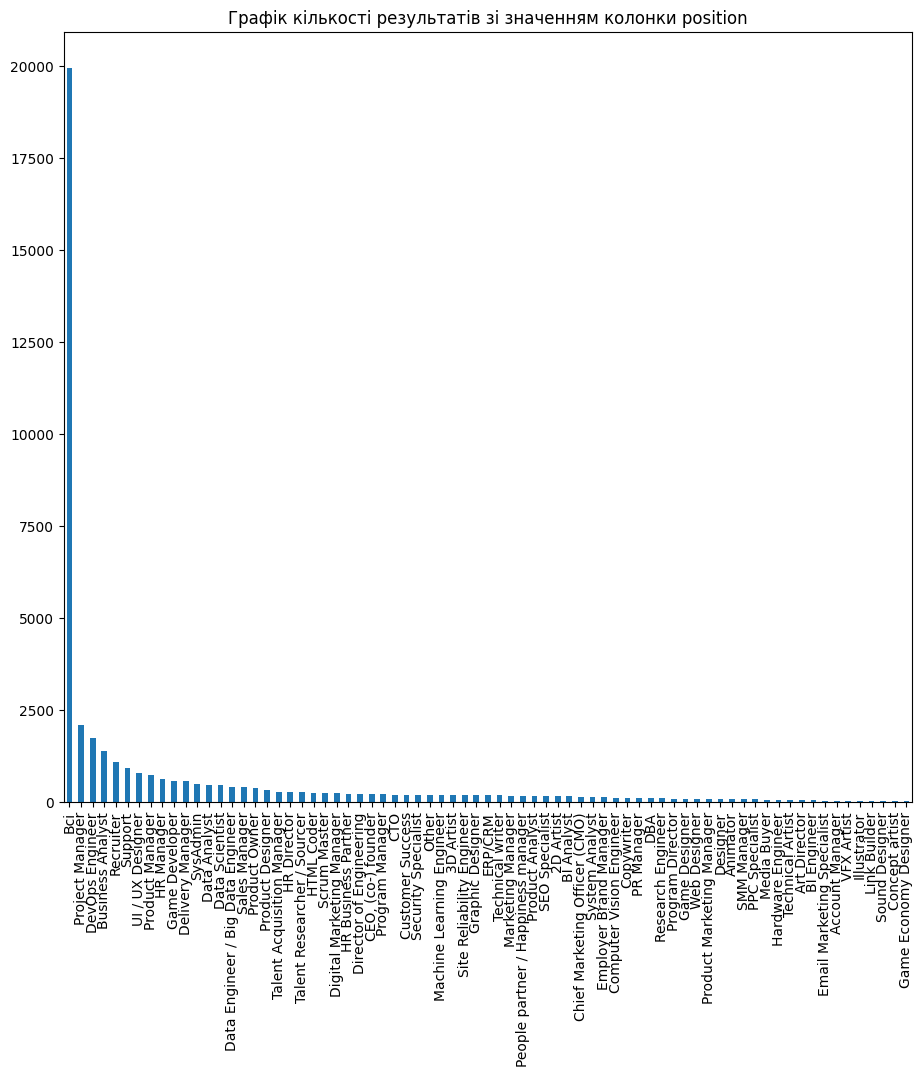

In [9]:
#@title The number of questionnaires depends on their parameters
# @markdown As we can see in the unique user questionnaires, there is enough data except for a few positions.
# @markdown All Cities, All Experiences, and All are expected to have the highest number of results. But the advantage of the parameters All positions is huge.
figsize = (12, 1.2 * len(df_unpacked['city'].unique()))
#plt.figure(figsize=figsize)
df_unpacked['city'].value_counts().plot(kind='bar')
plt.title('Графік кількості результатів зі значенням колонки city')
plt.show()

figsize = (12, 1.2 * len(df_unpacked['experience'].unique()))
#plt.figure(figsize=figsize)
df_unpacked['experience'].value_counts().plot(kind='bar')
plt.title('Графік кількості результатів зі значенням колонки experience')
plt.show()

figsize = (12, 1.2 * len(df_unpacked['salary'].unique()))
#plt.figure(figsize=figsize)
df_unpacked['salary'].value_counts().plot(kind='bar')
plt.title('Графік кількості результатів зі значенням колонки salary')
plt.show()

figsize = (0.15 *len(df_unpacked['position'].unique()), 10 )
plt.figure(figsize=figsize)
df_unpacked['position'].value_counts().plot(kind='bar')
plt.title('Графік кількості результатів зі значенням колонки position')
plt.show()

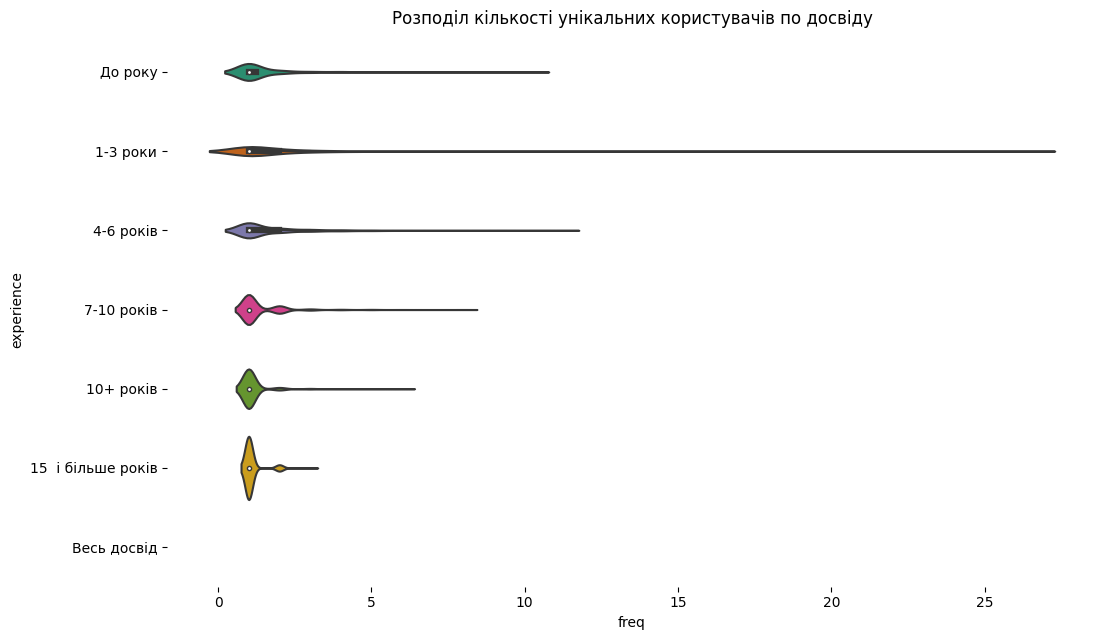

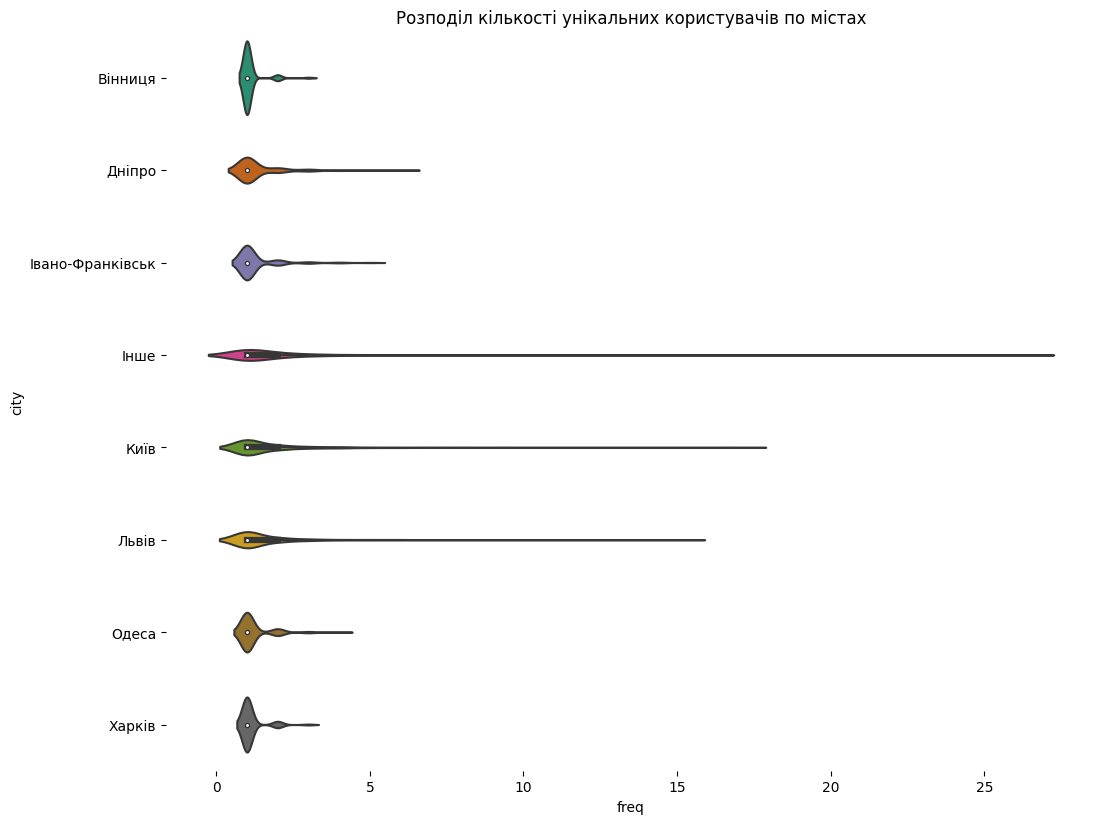

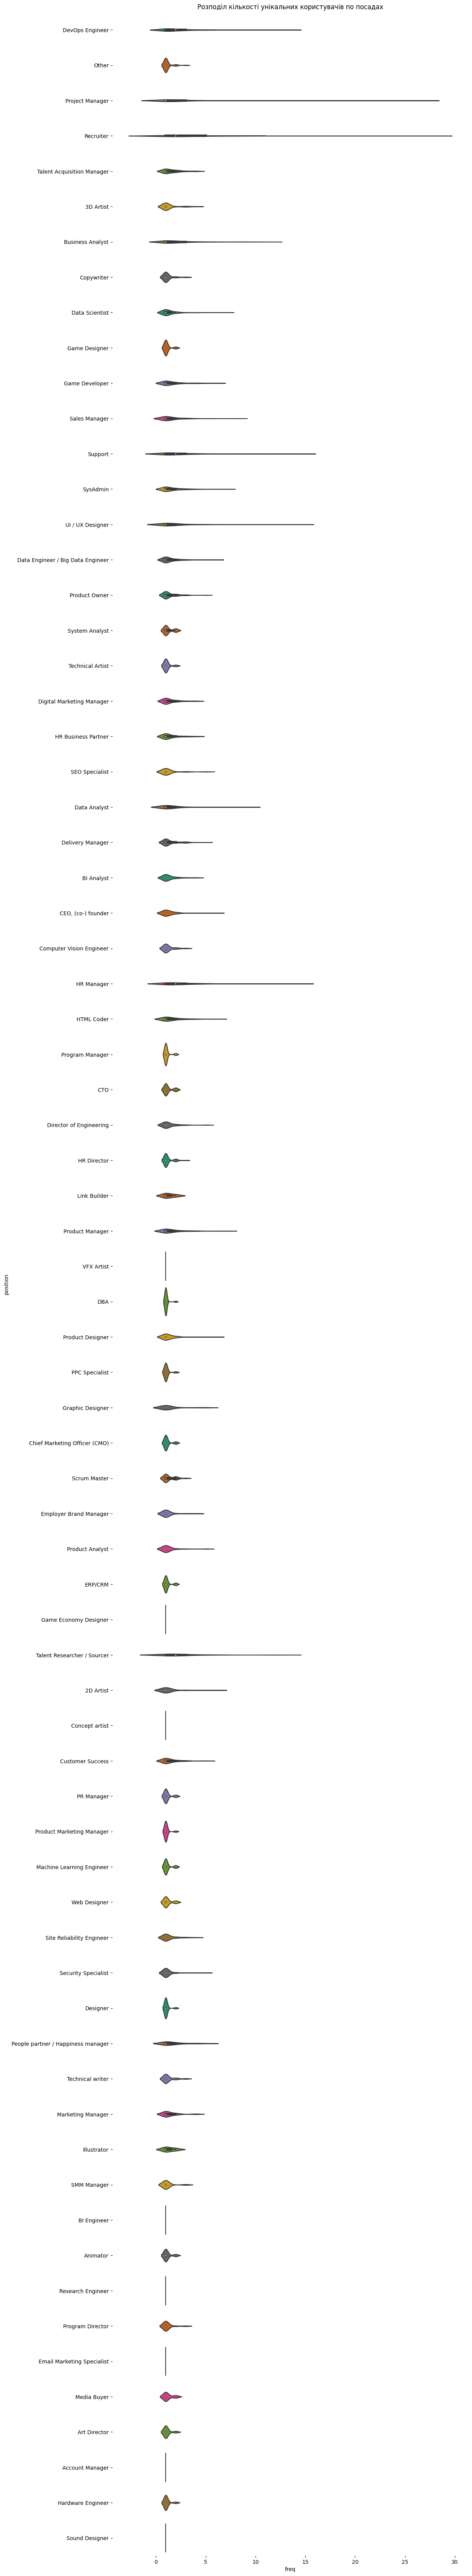

In [10]:
#@title Distribution of the number of unique users depending on their parameters
# @markdown As we can see in the unique user questionnaires there is enough data except for a few positions.
# @markdown Here we have sorted all the data containing aggregated data for city, experience, position.
# @markdown As we can see in the unique user questionnaires there is enough data except for a few positions.
df_sorted = df[~((df['city'] == 'Всі міста') | (df['experience'] == 'Весь досвід') | (df['position'] == 'Всі'))]
figsize = (12, 1.2 * len(df_sorted['experience'].unique()))
plt.figure(figsize=figsize)
plt.title("Розподіл кількості унікальних користувачів по досвіду")
sns.violinplot(df_sorted, x='freq', y='experience', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

figsize = (12, 1.2 * len(df_sorted['city'].unique()))
plt.figure(figsize=figsize)
plt.title("Розподіл кількості унікальних користувачів по містах")
sns.violinplot(df_sorted, x='freq', y='city', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

figsize = (12, 1.2 * len(df_sorted['position'].unique()))
plt.figure(figsize=figsize)
plt.title("Розподіл кількості унікальних користувачів по посадах")
sns.violinplot(df_sorted, x='freq', y='position', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Unpack dataset

In [11]:
#@title Unpack data
df_unpacked = df.loc[df.index.repeat(df['freq'])].reset_index(drop=True)
print(df_unpacked.head())
df_unpacked.info()

      city experience   salary                    position  freq  salary_idx
0  Вінниця   1-3 роки  0 - 500             DevOps Engineer     1           0
1  Вінниця   1-3 роки  0 - 500                       Other     1           0
2  Вінниця   1-3 роки  0 - 500             Project Manager     1           0
3  Вінниця   1-3 роки  0 - 500                   Recruiter     1           0
4  Вінниця   1-3 роки  0 - 500  Talent Acquisition Manager     1           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39880 entries, 0 to 39879
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        39880 non-null  object  
 1   experience  39880 non-null  category
 2   salary      39880 non-null  category
 3   position    39880 non-null  object  
 4   freq        39880 non-null  int64   
 5   salary_idx  39880 non-null  int64   
dtypes: category(2), int64(2), object(2)
memory usage: 1.3+ MB


In [12]:
#@title Info results of questionnaires with only generalizing values
df_unpacked_all = df_unpacked[((df_unpacked['city'] == 'Всі міста') | (df_unpacked['experience'] == 'Весь досвід') | (df_unpacked['position'] == 'Всі'))]
df_unpacked_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34895 entries, 4985 to 39879
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        34895 non-null  object  
 1   experience  34895 non-null  category
 2   salary      34895 non-null  category
 3   position    34895 non-null  object  
 4   freq        34895 non-null  int64   
 5   salary_idx  34895 non-null  int64   
dtypes: category(2), int64(2), object(2)
memory usage: 1.4+ MB


In [13]:
#@title Info the results of unique user questionnaires
df_unpacked_filtered = df_unpacked[~((df_unpacked['city'] == 'Всі міста') | (df_unpacked['experience'] == 'Весь досвід') | (df_unpacked['position'] == 'Всі'))]
df_unpacked_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4985 entries, 0 to 4984
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        4985 non-null   object  
 1   experience  4985 non-null   category
 2   salary      4985 non-null   category
 3   position    4985 non-null   object  
 4   freq        4985 non-null   int64   
 5   salary_idx  4985 non-null   int64   
dtypes: category(2), int64(2), object(2)
memory usage: 205.5+ KB


In [14]:
#@title Grouping data by city and calculating the average value (unique users)
# @markdown From this result, we can see that in general, cities have a different number of residents, but the average salary also depends on the city.
result_by_city = df_unpacked_filtered.groupby('city')['salary_idx'].agg(['mean', 'median', 'count'])
result_by_city.sort_values('mean')

,mean,median,count
city,,,
Харків,3.090909,2.0,77
Дніпро,3.426778,2.0,239
Одеса,3.946154,3.0,130
Вінниця,4.374233,3.0,163
Інше,4.474851,3.0,1849
Івано-Франківськ,4.514019,3.0,214
Львів,4.807256,4.0,882
Київ,4.930818,4.0,1431


## Let's review the data for the DevOps Engineer job in more detail

In [15]:
position_name = 'DevOps Engineer'
df_dev = df_unpacked.loc[df_unpacked['position'] == position_name]
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1720 entries, 0 to 24809
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        1720 non-null   object  
 1   experience  1720 non-null   category
 2   salary      1720 non-null   category
 3   position    1720 non-null   object  
 4   freq        1720 non-null   int64   
 5   salary_idx  1720 non-null   int64   
dtypes: category(2), int64(2), object(2)
memory usage: 71.5+ KB


<ipython-input-16-dbef17d2616b>:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='salary', y='experience', data=df_dev, palette='viridis', jitter=True)


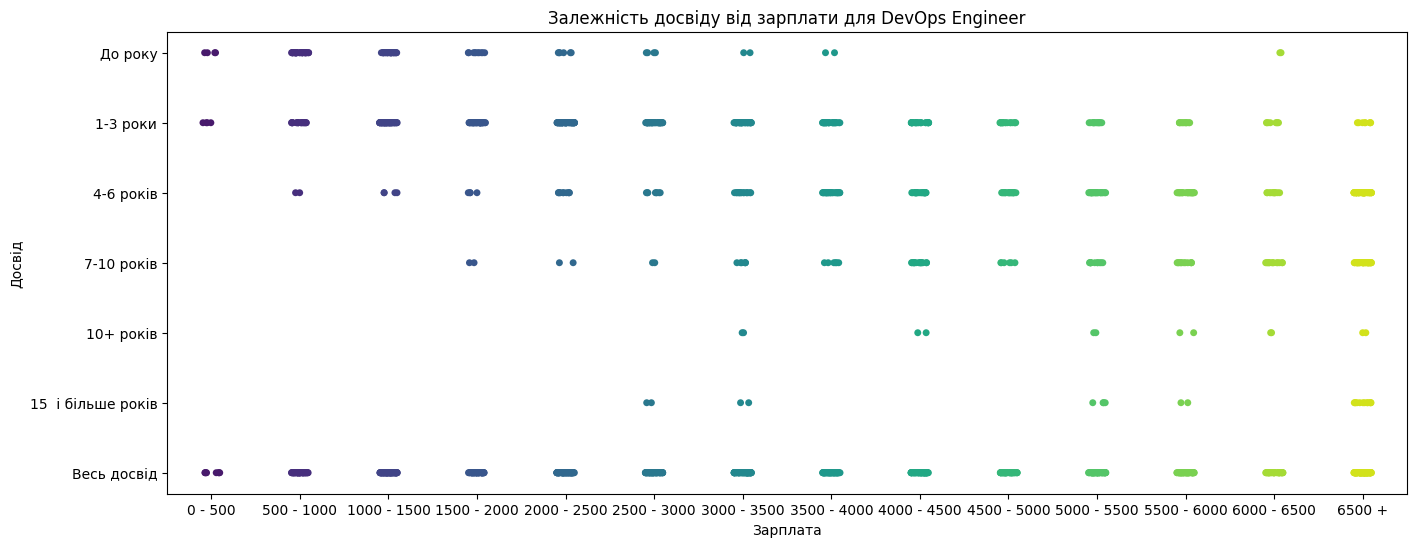

In [16]:
#@title Graph of the ratio of salaries to experience in the selected position
plt.figure(figsize=(16, 6))
sns.stripplot(x='salary', y='experience', data=df_dev, palette='viridis', jitter=True)
plt.title(f'Залежність досвіду від зарплати для {position_name}')
plt.xlabel('Зарплата')
plt.ylabel('Досвід')
plt.show()


<ipython-input-17-b865c5b6ed4f>:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='salary', y='experience', data=df_dev_unique, palette='viridis', jitter=True)


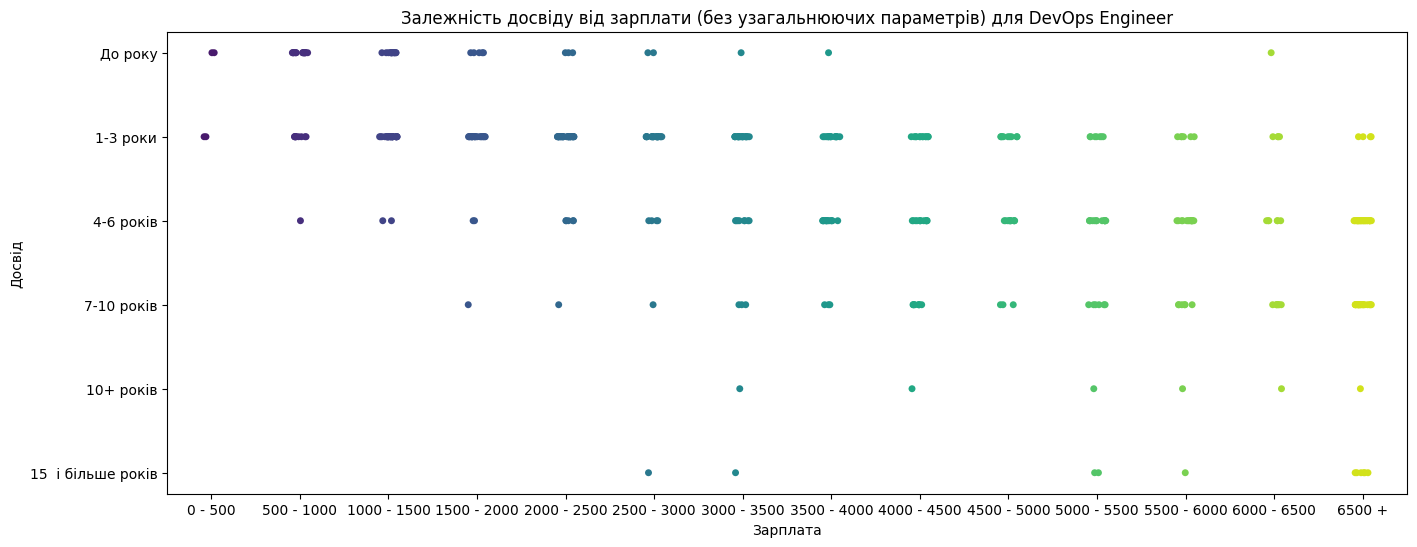

In [17]:
#@title Graph of the ratio of salaries to experience in the selected position (without generalizing parameters)
# @markdown Here it is better to see that there is a direct dependence of salaries on experience
df_dev_unique = df_unpacked_filtered.loc[df_unpacked_filtered['position'] == position_name]

plt.figure(figsize=(16, 6))
sns.stripplot(x='salary', y='experience', data=df_dev_unique, palette='viridis', jitter=True)
plt.title(f'Залежність досвіду від зарплати (без узагальнюючих параметрів) для {position_name}')
plt.xlabel('Зарплата')
plt.ylabel('Досвід')
plt.show()

<ipython-input-18-0acc2b529772>:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='salary', y='city', data=df_dev_unique, palette='viridis', jitter=True)


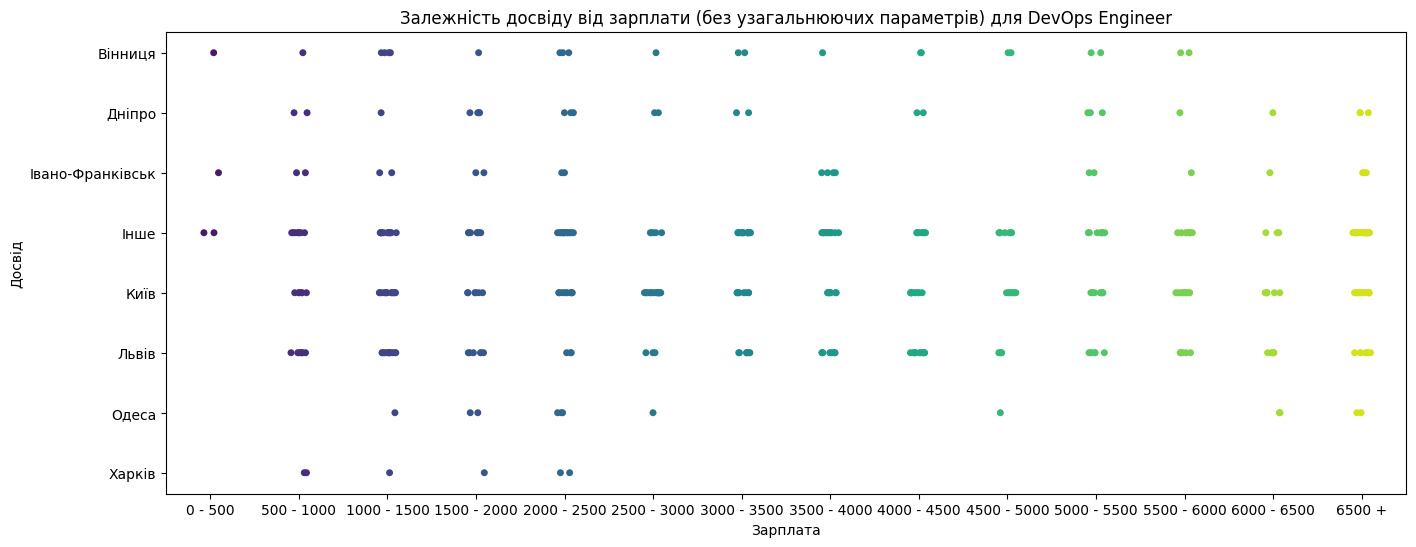

In [18]:
#@title Graph of the ratio of salaries to the city in the selected position (without generalizing parameters)
df_dev_unique = df_unpacked_filtered.loc[df_unpacked_filtered['position'] == position_name]

plt.figure(figsize=(16, 6))
sns.stripplot(x='salary', y='city', data=df_dev_unique, palette='viridis', jitter=True)
plt.title(f'Залежність досвіду від зарплати (без узагальнюючих параметрів) для {position_name}')
plt.xlabel('Зарплата')
plt.ylabel('Досвід')
plt.show()

In [19]:
#@title Grouping data by city and calculating the average value (unique users)
result_by_city = df_dev_unique.groupby('city')['salary_idx'].agg(['mean', 'median', 'count'])
result_by_city.sort_values('mean')

,mean,median,count
city,,,
Харків,2.500000,2.5,6
Вінниця,5.636364,5.5,22
Івано-Франківськ,6.500000,7.0,20
Дніпро,6.583333,5.5,24
Львів,6.896552,7.0,87
Одеса,7.000000,4.5,12
Інше,7.067669,7.0,133
Київ,7.150794,7.0,126


## Generalization of data

The dataset is data from the filtering of survey results, not pure survey results. It is possible to select pure user questionnaires in the amount of 4985 users.

There are no empty fields, but I focus on training on this particular pool of data, since 34,895 filtering results with generalizations will significantly affect the salary estimate.

In turn, I will try to train a certain neural model to evaluate these results.

#Train models

In [20]:
#@title CustomDataLoader
class CustomDataLoader(object):
  def fit(self, dataset, dict_salary_idx,
          dict_expirience_idx, dict_city_idx, dict_position_idx):
    self.dataset = dataset.copy()
    self.dict_salary_idx = dict_salary_idx
    self.dict_expirience_idx = dict_expirience_idx
    self.dict_city_idx = dict_city_idx
    self.dict_position_idx = dict_position_idx

    self.dict_idx_to_salary = {v: k for k, v in self.dict_salary_idx.items()}

  def load_data(self):
    if 'salary' in self.dataset.columns:
      self.dataset['salary_idx'] = self.dataset['salary'].map(self.dict_salary_idx)
      self.dataset['salary_idx'] = pd.to_numeric(self.dataset['salary_idx'])

    self.dataset['city_idx'] = self.dataset['city'].map(self.dict_city_idx)
    self.dataset['city_idx'] = pd.to_numeric(self.dataset['city_idx'])

    self.dataset['position_idx'] = self.dataset['position'].map(self.dict_position_idx)
    self.dataset['position_idx'] = pd.to_numeric(self.dataset['position_idx'])

    self.dataset['experience_idx'] = self.dataset['experience'].map(self.dict_expirience_idx)
    self.dataset['experience_idx'] = pd.to_numeric(self.dataset['experience_idx'])
    return self.dataset

  def uncode_predict(self, data):
    return [self.dict_idx_to_salary[val] for val in data]


## Model based on filtered data (clear users data)


In [21]:
train_data = df_unpacked_filtered.copy()[['city', 'experience', 'position', 'salary']]
#train_data = df_unpacked.copy()[['city', 'experience', 'position', 'salary']]

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4985 entries, 0 to 4984
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        4985 non-null   object  
 1   experience  4985 non-null   category
 2   position    4985 non-null   object  
 3   salary      4985 non-null   category
dtypes: category(2), object(2)
memory usage: 127.6+ KB


In [22]:
# @title Tokenazer
sorted_salary = ['0 - 500', '500 - 1000', '1000 - 1500',
                  '1500 - 2000', '2000 - 2500', '2500 - 3000',
                  '3000 - 3500', '3500 - 4000', '4000 - 4500',
                  '4500 - 5000', '5000 - 5500', '5500 - 6000',
                  '6000 - 6500', '6500 +']

sorted_expirience = ['До року', '1-3 роки', '4-6 років', '7-10 років',
                     '10+ років', '15  і більше років', 'Весь досвід']

city_vals = list(train_data['city'].unique())
position_vals = list(train_data['position'].unique())

# Токенізуємо міста, досвід, посади та зарплати. Це будуть основні наші параметри тренування
def idx_indexes_make(val_list):
  maked_dict = {}
  for i in range(len(val_list)):
    maked_dict[val_list[i]] = i
  return maked_dict

dict_salary_idx = idx_indexes_make(sorted_salary)
dict_expirience_idx = idx_indexes_make(sorted_expirience)
dict_city_idx = idx_indexes_make(city_vals)
dict_position_idx = idx_indexes_make(position_vals)


In [23]:
#@title Prepare and split data
loader = CustomDataLoader()
loader.fit(train_data, dict_salary_idx, dict_expirience_idx, dict_city_idx, dict_position_idx)
loaded_data = loader.load_data()
loaded_data.drop(['city','experience',	'position', 'salary'], axis=1, inplace=True)

X = loaded_data.drop("salary_idx", axis=1)
y = loaded_data["salary_idx"]

X = pd.get_dummies(X, columns=["city_idx","position_idx", "experience_idx"], dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
df_template_columns = X.columns

X.head()


,city_idx_0,city_idx_1,city_idx_2,city_idx_3,city_idx_4,city_idx_5,city_idx_6,city_idx_7,position_idx_0,position_idx_1,...,position_idx_68,position_idx_69,position_idx_70,position_idx_71,experience_idx_0,experience_idx_1,experience_idx_2,experience_idx_3,experience_idx_4,experience_idx_5
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
#@title Test models training
classifiers_models = [
    SVC(probability=True),
    LogisticRegression(max_iter=300, solver='newton-cg')]
filtered_trained_models = []
for model in classifiers_models:
  model.fit(X_train, y_train)
  filtered_trained_models.append(model)
del classifiers_models

In [25]:
# @title NN train
listen_rate_1 = 0.2 # @param {type:"number"}
eponch_num_1 = 8 # @param {type:"number"}
listen_rate_2 = 0.01 # @param {type:"number"}
eponch_num_2 = 8 # @param {type:"number"}
batch_size = 4 # @param {type:"number"}
# @markdown ===============
# @markdown Model parameters
input_dim = 86 # @param {type:"number"}
hidden_layers_1 = 64 # @param {type:"number"}
hidden_layers_2 = 32 # @param {type:"number"}
output_dim = 15 # @param {type:"number"}

class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len



class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers_1)
    self.linear2 = nn.Linear(hidden_layers_1, hidden_layers_2)
    self.output = nn.Linear(hidden_layers_2, output_dim)
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = torch.sigmoid(self.linear2(x))
    x = self.output(x)
    return x
  def predict(self, x):
    tensor_x = torch.Tensor(x.to_numpy())
    result = self(tensor_x)
    predicted_result = torch.argmax(result, dim = 1)
    return predicted_result.tolist()

def train_nn_model(model, eponch_num, listen_rate, trainloader, testloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=listen_rate)

  for epoch in range(eponch_num):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(trainloader):.5f}')
    model.eval()
    correct, total = 0, 0
    valid_loss = 0.0
    with torch.no_grad():
      for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        __, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      print(f'{epoch} epoch val loss : {valid_loss/len(testloader)}, test acc: {100 * correct // total}%')
  return model

#===============================

traindata = Data(X_train.to_numpy(), y_train.to_numpy())
trainloader = DataLoader(traindata, batch_size=batch_size,
                         shuffle=True, num_workers=1)

testdata = Data(X_test.to_numpy(), y_test.to_numpy())
testloader = DataLoader(testdata, batch_size=batch_size,
                        shuffle=True, num_workers=1)



model = Network()
print(model.parameters)
model = train_nn_model(model, eponch_num_1, listen_rate_1, trainloader, testloader)
model = train_nn_model(model, eponch_num_2, listen_rate_2, trainloader, testloader)
filtered_trained_models.append(model)

<bound method Module.parameters of Network(
  (linear1): Linear(in_features=86, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=15, bias=True)
)>
[1,  1122] loss: 2.46698
0 epoch val loss : 2.410682698249817, test acc: 18%
[2,  1122] loss: 2.41568
1 epoch val loss : 2.3797231712341307, test acc: 19%
[3,  1122] loss: 2.34370
2 epoch val loss : 2.2857449321746826, test acc: 20%
[4,  1122] loss: 2.25604
3 epoch val loss : 2.1996001138687133, test acc: 22%
[5,  1122] loss: 2.18978
4 epoch val loss : 2.2007301778793336, test acc: 23%
[6,  1122] loss: 2.15083
5 epoch val loss : 2.189352228164673, test acc: 20%
[7,  1122] loss: 2.12844
6 epoch val loss : 2.1328451986312866, test acc: 22%
[8,  1122] loss: 2.11917
7 epoch val loss : 2.152771890640259, test acc: 24%
[1,  1122] loss: 2.08085
0 epoch val loss : 2.1026415786743162, test acc: 25%
[2,  1122] loss: 2.07213
1 epoch val loss : 2.1005366230010987,

In [26]:
# @title Models metrics
def evaluate_metrics(y_true, y_pred):
  print(model)
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  print(f'Accuracy: {acc:.4f} | F1 Score: {f1:.4f}\n==================')

for model in filtered_trained_models:
  y_pred = model.predict(X_test)
  evaluate_metrics(y_test, y_pred)


SVC(probability=True)
Accuracy: 0.2545 | F1 Score: 0.1817
LogisticRegression(max_iter=300, solver='newton-cg')
Accuracy: 0.2665 | F1 Score: 0.1565
Network(
  (linear1): Linear(in_features=86, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=15, bias=True)
)
Accuracy: 0.2565 | F1 Score: 0.1118


#Interface

In [27]:
#@title Program

city = "\u0406\u0432\u0430\u043D\u043E-\u0424\u0440\u0430\u043D\u043A\u0456\u0432\u0441\u044C\u043A" # @param ['Вінниця', 'Дніпро', 'Івано-Франківськ', 'Київ', 'Львів', 'Одеса', 'Харків', 'Інше']
experience = "7-10 \u0440\u043E\u043A\u0456\u0432" # @param ['До року', '1-3 роки', '4-6 років', '7-10 років', '10+ років', '15  і більше років', 'Весь досвід']
position = "Data Scientist" # @param ['DevOps Engineer', 'Other', 'Project Manager', 'Recruiter', 'Talent Acquisition Manager', '3D Artist', 'Business Analyst', 'Copywriter', 'Data Scientist', 'Game Designer', 'Game Developer', 'Sales Manager', 'Support', 'SysAdmin', 'UI / UX Designer', 'Data Engineer / Big Data Engineer', 'Product Owner', 'System Analyst', 'Technical Artist', 'Digital Marketing Manager', 'HR Business Partner', 'SEO Specialist', 'Data Analyst', 'Delivery Manager', 'BI Analyst', 'CEO, (co-) founder', 'Computer Vision Engineer', 'HR Manager', 'HTML Coder', 'Program Manager', 'CTO', 'Director of Engineering', 'HR Director', 'Link Builder', 'Product Manager', 'VFX Artist', 'DBA', 'Product Designer', 'PPC Specialist', 'Graphic Designer', 'Chief Marketing Officer (CMO)', 'Scrum Master', 'Employer Brand Manager', 'Product Analyst', 'ERP/CRM', 'Game Economy Designer', 'Talent Researcher / Sourcer', '2D Artist', 'Concept artist', 'Customer Success', 'PR Manager', 'Product Marketing Manager', 'Machine Learning Engineer', 'Web Designer', 'Site Reliability Engineer', 'Security Specialist', 'Designer', 'People partner / Happiness manager', 'Technical writer', 'Marketing Manager', 'Illustrator', 'SMM Manager', 'BI Engineer', 'Animator', 'Research Engineer', 'Program Director', 'Email Marketing Specialist', 'Media Buyer', 'Art Director', 'Account Manager', 'Hardware Engineer', 'Sound Designer']
# @markdown Рекомендую використати MLR модель
trained_model = "MLR" # @param ["NN", "MLR", "SVC"]
data = {'city': [city],
        'experience': [experience],
        'position': [position]}

if trained_model == 'SVC':
  set_model = filtered_trained_models[0]
elif trained_model == 'MLR':
  set_model = filtered_trained_models[1]
else:
  set_model = filtered_trained_models[2]

test_df = pd.DataFrame(data)
loader = CustomDataLoader()
loader.fit(test_df, dict_salary_idx, dict_expirience_idx, dict_city_idx, dict_position_idx)
loaded_data = loader.load_data()
loaded_data.drop(['city','experience',	'position'], axis=1, inplace=True)

test_df = pd.DataFrame([[0]*len(df_template_columns)], columns=df_template_columns)
columns = list(loaded_data.columns)
result = loaded_data.iloc[0]
for col_name, val in result.items():
  column_name = col_name+'_' +str(val)
  test_df.iloc[0][column_name] = 1

#test_df
predicted_class = set_model.predict(test_df)
print(f'Excepted salary: {loader.uncode_predict(predicted_class)[0]}$\nPlease note that this result does not \ntake into account the requirements of your project, \ncandidate\'s English skills, education, etc.')

Excepted salary: 6500 +$
Please note that this result does not 
take into account the requirements of your project, 
candidate's English skills, education, etc.
